In [2]:
import os
import sys

import copy
import numpy as onp
from astropy.cosmology import Planck18
import tqdm

PACKAGE_PARENT = '..'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd())))
sys.path.append(SCRIPT_DIR)


In [3]:
import gwfast.gwfastGlobals as glob

In [4]:
alldetectors = copy.deepcopy(glob.detectors)
print('All available detectors are: '+str(list(alldetectors.keys())))

# select only 3G detectors
G3detectors = {det:alldetectors[det] for det in ['ETS', 'CE1Id']}
print('Using detectors '+str(list(G3detectors.keys())))


All available detectors are: ['L1', 'H1', 'Virgo', 'KAGRA', 'LIGOI', 'ETS', 'ETMR', 'ETSL', 'ETMRL45d', 'ETMRLpar', 'CE1Id', 'CE2NM', 'CE2NSW']
Using detectors ['ETS', 'CE1Id']


In [5]:
# Set tge psds
G3detectors['ETS']['psd_path'] = os.path.join(glob.detPath, 'ET_designs_comparison_paper', 'HF_only', 'ETLength20km.txt')
G3detectors['CE1Id']['psd_path'] = os.path.join(glob.detPath, 'ce_strain', 'cosmic_explorer_40km_lf.txt')

In [6]:
from gwfast.waveforms import IMRPhenomHM
from gwfast.signal import GWSignal
from gwfast.network import DetNet
from fisherTools import CovMatr, compute_localization_region, check_covariance, fixParams

TEOBResumS is not installed, only the GWFAST waveform models are available, namely: TaylorF2, IMRPhenomD, IMRPhenomD_NRTidalv2, IMRPhenomHM and IMRPhenomNSBH


In [7]:
my3Gsignals = {}

for d in G3detectors.keys():

    my3Gsignals[d] = GWSignal(IMRPhenomHM(), 
                psd_path=G3detectors[d]['psd_path'],
                detector_shape = G3detectors[d]['shape'],
                det_lat= G3detectors[d]['lat'],
                det_long=G3detectors[d]['long'],
                det_xax=G3detectors[d]['xax'], 
                verbose=True,
                useEarthMotion = True,
                fmin=10.,
                IntTablePath=None) 
        
my3GNet = DetNet(my3Gsignals)      

Using ASD from file /Users/pietro/Documents/Uni/thesis/gwfast/psds/ET_designs_comparison_paper/HF_only/ETLength20km.txt 
Initializing jax...
Jax local device count: 8
Jax  device count: 8
Using ASD from file /Users/pietro/Documents/Uni/thesis/gwfast/psds/ce_strain/cosmic_explorer_40km_lf.txt 
Initializing jax...
Jax local device count: 8
Jax  device count: 8


In [8]:
N = 10
zs = onp.random.uniform(1e-2, 5, N)

dLs = Planck18.luminosity_distance(zs).value/1000

Mcs = onp.random.normal(loc=1.156, scale=0.056, size=N) 

events_rand = {'Mc': Mcs*(1.+zs), 
               'eta': onp.random.uniform(0.24, 0.25, N), 
               'dL': dLs, 
               'theta':onp.arccos(onp.random.uniform(-1., 1., N)), 
               'phi':onp.random.uniform(0., 2.*onp.pi, N), 
               'iota':onp.arccos(onp.random.uniform(-1., 1., N)), 
               'psi':onp.random.uniform(0., 2.*onp.pi, N), 
               'tcoal':onp.random.uniform(0., 1., N), 
               'Phicoal': onp.random.uniform(0., 2.*onp.pi, N),
               'chi1z':onp.random.uniform(-.05, .05, N), 
               'chi2z':onp.random.uniform(-.05, .05, N), 
               'Lambda1':onp.random.uniform(0., 2000., N), 
               'Lambda2':onp.random.uniform(0., 2000., N),
              }

In [9]:
SNR = my3GNet.SNR(events_rand)
print(SNR)

[ 7.45032223 18.52690745  7.86974064 15.03638525  5.21903535 82.03431475
 12.37832316  5.41275905  7.25124496  5.82019809]


In [10]:
FM = my3GNet.FisherMatr(events_rand)

Computing Fisher for ETS...
Computing derivatives...
Filling matrix for arm 1...
Computing derivatives...
Filling matrix for arm 2...
Filling matrix for arm 3...
Computing Fisher for CE1Id...
Computing derivatives...
Done.


In [11]:
FM

array([[[ 1.07048495e+07,  1.19433352e+11,  9.09763727e+07, ...,
          2.27948444e+07,  7.81323848e+07,  7.83373498e+06],
        [-6.86064000e+06, -3.62765222e+09, -2.48143284e+07, ...,
         -9.15286542e+06, -3.04572282e+07, -5.68404721e+06],
        [ 1.28245825e-01,  5.41603814e+02, -9.31146261e-01, ...,
         -1.09683787e-01, -2.04489461e+00, -4.76875966e-02],
        ...,
        [ 2.36617931e+04,  6.32331272e+06,  7.39758405e+04, ...,
          2.52793735e+04,  6.35030410e+04,  1.59654389e+04],
        [-1.54906582e+06, -1.11841360e+09, -6.91764842e+06, ...,
         -2.22481179e+06, -6.38194523e+06, -1.25594887e+06],
        [-1.21575962e+06, -8.34990459e+08, -5.13735678e+06, ...,
         -1.49560908e+06, -4.37207835e+06, -8.13681965e+05]],

       [[-6.86064000e+06, -3.62765222e+09, -2.48143284e+07, ...,
         -9.15286542e+06, -3.04572282e+07, -5.68404721e+06],
        [ 4.57360629e+06,  1.15218651e+08,  7.01410005e+06, ...,
          3.81526684e+06,  1.22256411e

In [12]:
totCov, inversion_err = CovMatr(FM)

In [14]:
_ = check_covariance(FM, totCov)

Inversion errors: [4.46380000e-09 3.36905941e-07 1.19034667e-08 4.66243364e-08
 7.02493708e-09 4.58210707e-07 4.03233571e-08 7.81437848e-09
 1.21799530e-08 2.37923814e-09]
diagonal-1 = [array([ 1.49213975e-13,  1.70707892e-12, -9.56808417e-16,  2.36529546e-15,
        9.47159018e-16,  2.48065457e-15, -1.14006027e-14, -1.18127730e-12,
        5.80369086e-14, -2.78305379e-10,  2.17369234e-10], dtype=float128), array([ 4.22772928e-13,  6.05098194e-11,  1.85181731e-16,  4.23966418e-15,
        1.50851553e-14,  9.00321484e-16,  2.19962937e-15, -7.08055836e-12,
        3.01980663e-14,  2.33012543e-09, -2.78305379e-10], dtype=float128), array([ 7.13029635e-12,  2.64321898e-12,  1.07923653e-14, -9.03721542e-14,
        6.24500451e-16,  1.50140317e-15, -6.24222896e-14,  2.15294449e-12,
        7.23865412e-14,  1.25555744e-09,  1.47474566e-09], dtype=float128), array([-9.41113854e-12,  9.25410859e-11, -1.07468830e-14, -1.45883305e-13,
       -2.25597319e-13,  7.66053887e-14, -2.50188759e-13, -7.

In [43]:
noiseCE = my3Gsignals['CE1Id'].noiseCurve
noiseET = my3Gsignals['ETS'].noiseCurve
maxim = my3Gsignals['ETS'].fmax
minim = my3Gsignals['ETS'].fmin

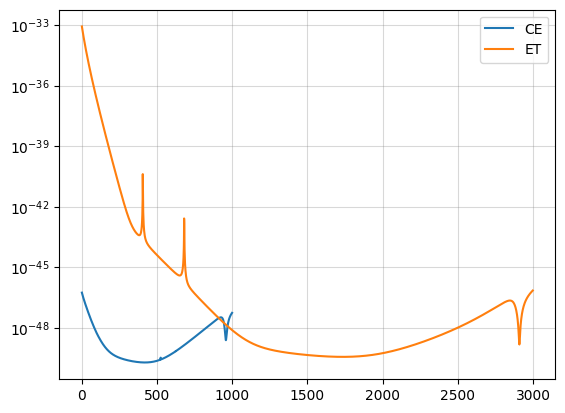

In [35]:
import matplotlib.pyplot as plt
plt.plot(noiseCE, label = 'CE')
plt.plot(noiseET, label = 'ET')
plt.legend()
plt.grid(c = 'gray', alpha = 0.3)
plt.yscale('log')

In [54]:
diag = totCov.diagonal()

In [58]:
sigma_Mc = diag[0,0]

In [62]:
from scipy import stats

mc_pdf = stats.norm(loc = Mcs[0], scale = sigma_Mc)
X = onp.linspace(Mcs[0]-5*sigma_Mc, Mcs[0]+5*sigma_Mc, 1000)
y = mc_pdf.pdf(X)

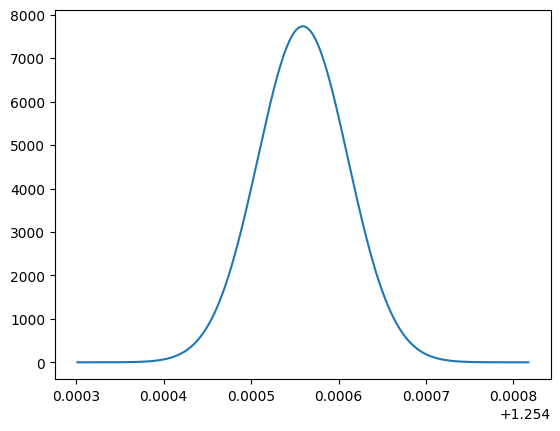

In [63]:
plt.plot(X, y)